# Scrapper de Backlinks

> Récupère le contenu de chacune des pages placées dans list_websites correspondant aux sites des liens entrants. Cette liste (/Ressources/PNPCbacklinkperdomain.csv) a été récupérée sur [ahrefs.com](https://help.ahrefs.com/en/articles/2073233-what-are-linked-domains). 

> Stocke le résultat dans ndf qui conditionne la variable "fichier de sortie". Celle-ci est à adapter pour pointer sur une zone correcte de votre drive

> La variable de sortie est de type dictionnaire pour conserver les url sources (flexibilité pour pouvoir corriger). Cf. commentaires infra.


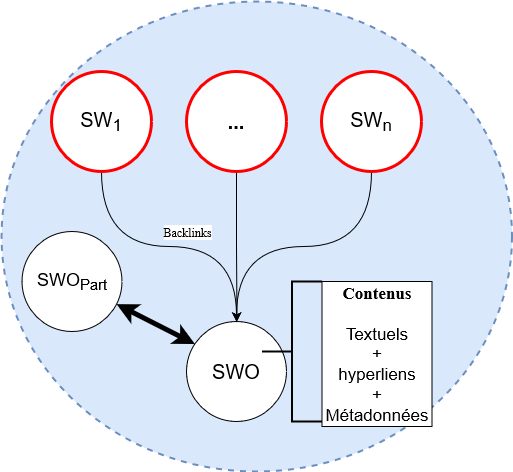

In [ ]:
from IPython.display import Image
Image("/content/DistorsionCom/Ressources/topologie.png")

## Récupération de librairies et ressources pour alléger le colab et partager entre colabs
> j'ai pas mieux : dépôt git pour les ressources, récupération dans le colab et import comme librairie. 


In [ ]:
from google.colab import files
import os

# Si le dossier est déjà monté dans l'environnement d'exécution, on passe
try:
  !git clone https://github.com/Patent2net/DistorsionCom.git
  os.chdir('DistorsionCom')
except:
  print("Dossier déjà monté, vous pouvez continuer l'exécution")



stockageEntree = "/content/DistorsionCom"
stockageSortie = "/content/DistorsionCom"

Cloning into 'DistorsionCom'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 120 (delta 29), reused 106 (delta 15), pack-reused 0
Receiving objects: 100% (120/120), 9.90 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (29/29), done.



---
Personnalisation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Récupérer les sorties sur son drive (creer un dossier "OUT")
stockageSortie = "/content/drive/MyDrive"



---



In [ ]:
import requests, re, pickle
from bs4 import BeautifulSoup
from  urllib import parse 
import pandas as pd

from pprint import pprint as pp

## Les sites de référence

In [ ]:
# un peu d'automatisation
CatSites = dict() # catégories de SWO en clé = (liste URL, fichier de sortie)
                  # le fichier de sortie n'est pas vraiment utile en fait, la clé peut être utilisée

In [ ]:

stats = dict()

for ndf in os.listdir(stockageEntree +"/OUT/ContenusSites/"):
  if not ndf.startswith('.'):
    fichierEntree = stockageEntree +'/OUT/ContenusSites/' +ndf
    with open (fichierEntree, 'rb') as  fictemp: #pour ouvrir les contenus 
      soup = pickle.load(fictemp)
    CatSites [ndf.replace('.pkl', '')] = [parse.urlparse(url).netloc for url in soup.keys()] # reconstruction des listes d'URL
                                                                                              # seul le DNS est conservé
    data  = [len(soup [url]) for url in soup.keys()]
    donnees = pd.DataFrame.from_dict(data)
    stats[ndf .replace('.pkl', '')] = donnees.describe()


In [ ]:
pp(stats)

In [ ]:
print (CatSites.keys())

dict_keys(['mairies', 'restauration', 'Hebergement', 'Gouv', 'locations', 'oTourism', 'organisations', 'Services', 'parcs'])


# Récupération des backlinks


## Récupération des partenaires

NIVEAU1PNPC.csv contient la liste des sites cités par le site du parc (http://www.portcros-parcnational.fr/fr). Cette liste a été récupérée par le logiciel [Hyphe](https://github.com/medialab/hyphe) du Médialab SciencePo Paris.

In [ ]:
with open (stockageEntree +"/Ressources/NIVEAU1-PNPC.csv", "r") as partners:
  donnee= partners.readlines()

In [ ]:
partenaires = []
for lig in donnee[1:]:
  urls = lig.split(";")[2]
  partenaires.extend(urls.split())

In [ ]:
partenairesPropres = []

In [ ]:
for url in partenaires:
  url = url.strip()
  url = url.replace('"', "")

  urlP = parse.urlparse(url)
  partenairesPropres.append(urlP.scheme + '://' + urlP.hostname)


## Backlinks

In [ ]:
backlinks=pd.read_csv(stockageEntree +"/Ressources/PNPCbacklinkperdomain.csv", delimiter=';')

> La collecte des backlinks pourrait être parrallélisée (un get par domain ne nuit pas à la règle des robots). Mais certains sites peuvent être indisponibles ou ne pas répondre dans les temps. La librairie grequest fonctionne mais donne des erreurs/avertissements que nous n'avons pas résolus. Du coup, ce qui suit est sur un séquençage des requêtes GET pour chaque url de la liste.

Notes :

* Il faut relancer la collecte plusieurs fois : celle-ci dure plus longtemps qu'une session colab (probablement parce que le collecteur tombe sur un "attracteur"). 
* La zone d'information d'exécution peut rester figée comme ci-dessous par ex. Il faut alors interrompre la requête en cours en appuyant une fois sur le bouton d'exécution



## Mémo

In [ ]:
BadUrl = []
DoneDns = []
urlDns = []

In [ ]:
urls = backlinks ["Referring Page URL"]

In [ ]:
# la durée de collecte peut être longue. Dès fois il faut même arrêter l'exécution (appuyer une fois sur le carré) 
# si la zonne d'information en bas du navigateur ne semble plus évoluer
# ces lignes permet de reprendre là où ce sera arrêté si tout venait à planter.
if 'backlinks.pkl' in os.listdir(stockageSortie + '/OUT/ContenusBacklinks/'):
  with open(stockageSortie + '/OUT/ContenusBacklinks/backlinks.pkl', 'rb') as fic:
    data = pickle.load(fic)
    soup = data
  Done = list(data.keys())
if 'backlinksBad.pkl' in os.listdir(stockageSortie + '/OUT/ContenusBacklinks/'):
  with open(stockageSortie + '/OUT/ContenusBacklinks/backlinksBad.pkl', 'rb') as fic:
    BadUrl = pickle.load(fic)
  

In [ ]:
data

In [ ]:
# time.sleep(20)
fichierDeSortie = stockageSortie + '/OUT/ContenusBacklinks/backlinks.pkl'
fichierDeSortieBad = stockageSortie + '/OUT/ContenusBacklinks/backlinksBad.pkl'

for url in urls:
  if url not in Done and url not in BadUrl:
    try:
      BadUrl.append(url) # au cas où çà plante
      repons = requests .get(url)
      BadUrl.remove(url) # ben çà a pas planté
      tempoSoup= BeautifulSoup(repons.content, "html.parser")
      if tempoSoup.title is not None:
          titre = tempoSoup.title.text 
      else:
          titre = ""

      texte = [x.get_text() for x in tempoSoup.find_all('p')]
      # Nettoyage bas niveau 
      soup [url] = titre + '\n' + "\n".join(texte)
      re.sub('^a-zA-ZàâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ', ' ', soup [url])
      soup[url] = soup[url].replace("\xa0", " ")
      soup[url] = soup[url].replace("\n", " ")
      soup[url] = soup[url].replace("’", "'")
      soup[url] = soup[url].translate('utf8')
      dictionary = {"\\": ""}
      transtable = soup[url].maketrans(dictionary)
      soup[url] = soup[url].translate(transtable)
      soup[url] = str(soup [url])
      Done.append(url)
      with open (fichierDeSortie, 'wb') as  fictemp: #on met tous les contenus dans un pickle
        pickle.dump(soup, fictemp)
    except:

      BadUrl.append(url)
      tempo = parse.urlparse(url)
      urlDns.append(tempo.scheme + '://'+ tempo.netloc)
      
      ## possibilité de collecter au niveau DNS si la page avait disparu
      ## Non fait ici
      with open (fichierDeSortieBad, 'wb') as  fictemp: #on met tous les contenus dans un pickle
        pickle.dump(BadUrl, fictemp)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [ ]:
print("nb de sites traités", len(soup.keys()))
print("nb de sites collectés niveau DNS",len(urlDns))
print("nb de sites HS (base URL ou niveau DNS)", len(BadUrl))

nb de sites collectés 867
nb de sites collectés niveau DNS 18
nb de sites HS (base URL ou niveau DNS) 394


## Commentaires


* cf. commentaires du scrapper
* Sauvegarde des données textuelles dans un format pickle dictionnaire
  dico [url] = 'contenu scrappé'



In [ ]:
soup.keys()

dict_keys(['http://www.vanoise-parcnational.fr/fr', 'http://www.pyrenees-parcnational.fr/fr', 'http://www.cevennes-parcnational.fr/fr', 'http://www.ecrins-parcnational.fr/', 'http://www.mercantour-parcnational.fr/fr', 'http://www.guadeloupe-parcnational.fr/fr', 'http://www.parc-amazonien-guyane.fr/fr', 'http://www.reunion-parcnational.fr/fr', 'http://www.calanques-parcnational.fr/fr', 'http://www.forets-parcnational.fr/fr', 'http://orca.over-blog.com/article-4032267.html', 'http://www.absoluflassans.be/klimaat/', 'http://www.kvalr.net/location/', 'https://blog.association-bernica.net/correspondants-mecenat-dans-les-etablissements-publics-nationaux-sous-tutelle/', 'http://fouchepate.blogspot.com/2007/01/la-presqule-de-giens.html', 'https://www.marseilleveyre.org/br/cultura/20201005-exposição-fotográfica-sobre-incêndios-florestais-na-frança-dialoga-com-catástrofes-na-amazônia', 'http://asspplongee.over-blog.com/page/13', 'https://chambresdhotes-provenceazur.com/repere_en.html', 'http://w

In [ ]:
soup ['http://www.vanoise-parcnational.fr/fr']

In [ ]:
toutesSoupes = '\n'.join(soup.values())